In [291]:
import mysql.connector
import os
from dotenv import load_dotenv
import pandas as pd
load_dotenv()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

In [292]:
conn = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database='dublindb'
)
cursor = conn.cursor()

In [293]:
query = '''
    SELECT ts_contact_at, ts_reply_at, ts_accepted_at, ts_booking_at, time_to_reply, ds_checkin, ds_checkout, n_guests, n_messages
    FROM contacts;
'''
cursor.execute(query)
res = cursor.fetchall()

In [294]:
cols = ['ts_contact_at', 'ts_reply_at', 'ts_accepted_at', 'ts_booking_at', 'time_to_reply', 'ds_checkin', 'ds_checkout', 'n_guests', 'n_messages']
df = pd.DataFrame(res, columns=cols)
df.head()

,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,time_to_reply,ds_checkin,ds_checkout,n_guests,n_messages
0,2014-10-04 16:26:28.0,2014-10-04 16:26:28.0,2014-10-04 16:26:28.0,2014-10-04 16:26:28.0,0,2014-10-13,2014-10-15,2,13
1,2014-11-04 09:10:03.0,2014-11-04 09:45:50.0,2014-11-04 09:45:50.0,2014-11-04 12:20:46.0,2147,2014-11-27,2014-11-30,1,10
2,2014-10-10 12:02:50.0,2014-10-10 15:07:01.0,None,None,11051,2014-10-17,2014-10-19,2,3
3,2014-10-10 15:23:53.0,None,None,None,0,2014-10-17,2014-10-19,2,2
4,2014-10-10 15:22:26.0,2014-10-10 15:24:26.0,2014-10-10 15:24:26.0,2014-10-10 15:52:42.0,120,2014-10-17,2014-10-19,2,14


In [295]:
le = LabelEncoder()
df['ts_contact_at'] = le.fit_transform(df['ts_contact_at'])
df['ts_reply_at'] = le.fit_transform(df['ts_reply_at'])
df['ts_accepted_at'] = le.fit_transform(df['ts_accepted_at'])
df['ds_checkin'] = le.fit_transform(df['ds_checkin'])
df['ds_checkout'] = le.fit_transform(df['ds_checkout'])
df.head()

,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,time_to_reply,ds_checkin,ds_checkout,n_guests,n_messages
0,2363,2013,929,2014-10-04 16:26:28.0,0,12,13,2,13
1,7362,6797,3413,2014-11-04 12:20:46.0,2147,57,59,1,10
2,4581,4154,3627,None,11051,16,17,2,3
3,4646,7207,3627,None,0,16,17,2,2
4,4644,4158,2007,2014-10-10 15:52:42.0,120,16,17,2,14


In [296]:
df['booked'] = df['ts_booking_at'].apply(lambda x: 1 if x is not None else 0)
df.drop('ts_booking_at', axis=1, inplace=True)
df.head()

,ts_contact_at,ts_reply_at,ts_accepted_at,time_to_reply,ds_checkin,ds_checkout,n_guests,n_messages,booked
0,2363,2013,929,0,12,13,2,13,1
1,7362,6797,3413,2147,57,59,1,10,1
2,4581,4154,3627,11051,16,17,2,3,0
3,4646,7207,3627,0,16,17,2,2,0
4,4644,4158,2007,120,16,17,2,14,1


In [297]:
# correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,ts_contact_at,ts_reply_at,ts_accepted_at,time_to_reply,ds_checkin,ds_checkout,n_guests,n_messages,booked
ts_contact_at,1.000000,0.847743,0.369152,-0.054220,0.301537,0.281970,0.058028,0.040523,0.093871
ts_reply_at,0.847743,1.000000,0.459021,0.022523,0.239872,0.223955,0.032612,-0.072429,-0.008901
ts_accepted_at,0.369152,0.459021,1.000000,0.088823,0.140674,0.144273,0.038242,-0.367687,-0.479332
time_to_reply,-0.054220,0.022523,0.088823,1.000000,0.041720,0.051544,0.041837,-0.070757,-0.088011
ds_checkin,0.301537,0.239872,0.140674,0.041720,1.000000,0.977857,0.341459,-0.062696,-0.035224
ds_checkout,0.281970,0.223955,0.144273,0.051544,0.977857,1.000000,0.307855,-0.065001,-0.057210
n_guests,0.058028,0.032612,0.038242,0.041837,0.341459,0.307855,1.000000,-0.034093,-0.048828
n_messages,0.040523,-0.072429,-0.367687,-0.070757,-0.062696,-0.065001,-0.034093,1.000000,0.603536
booked,0.093871,-0.008901,-0.479332,-0.088011,-0.035224,-0.057210,-0.048828,0.603536,1.000000


In [298]:
X = df.drop('booked', axis=1)
y = df['booked']

In [299]:
X.head()

,ts_contact_at,ts_reply_at,ts_accepted_at,time_to_reply,ds_checkin,ds_checkout,n_guests,n_messages
0,2363,2013,929,0,12,13,2,13
1,7362,6797,3413,2147,57,59,1,10
2,4581,4154,3627,11051,16,17,2,3
3,4646,7207,3627,0,16,17,2,2
4,4644,4158,2007,120,16,17,2,14


In [300]:
y

0       1
1       1
2       0
3       0
4       1
       ..
7818    0
7819    0
7820    0
7821    0
7822    0
Name: booked, Length: 7823, dtype: int64

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## RandomForestClassifier

In [302]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

In [303]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [304]:
classifier_rf.oob_score_

0.9150840029218408

In [305]:
classifier_rf.score(X_train, y_train)

0.9191015339663988

In [306]:
classifier_rf.score(X_test, y_test)

0.9233063485300383

Param Sweep

In [307]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [308]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [309]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [310]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [311]:
grid_search.best_score_

0.9176406135865596

In [312]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [313]:
rf_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Plot

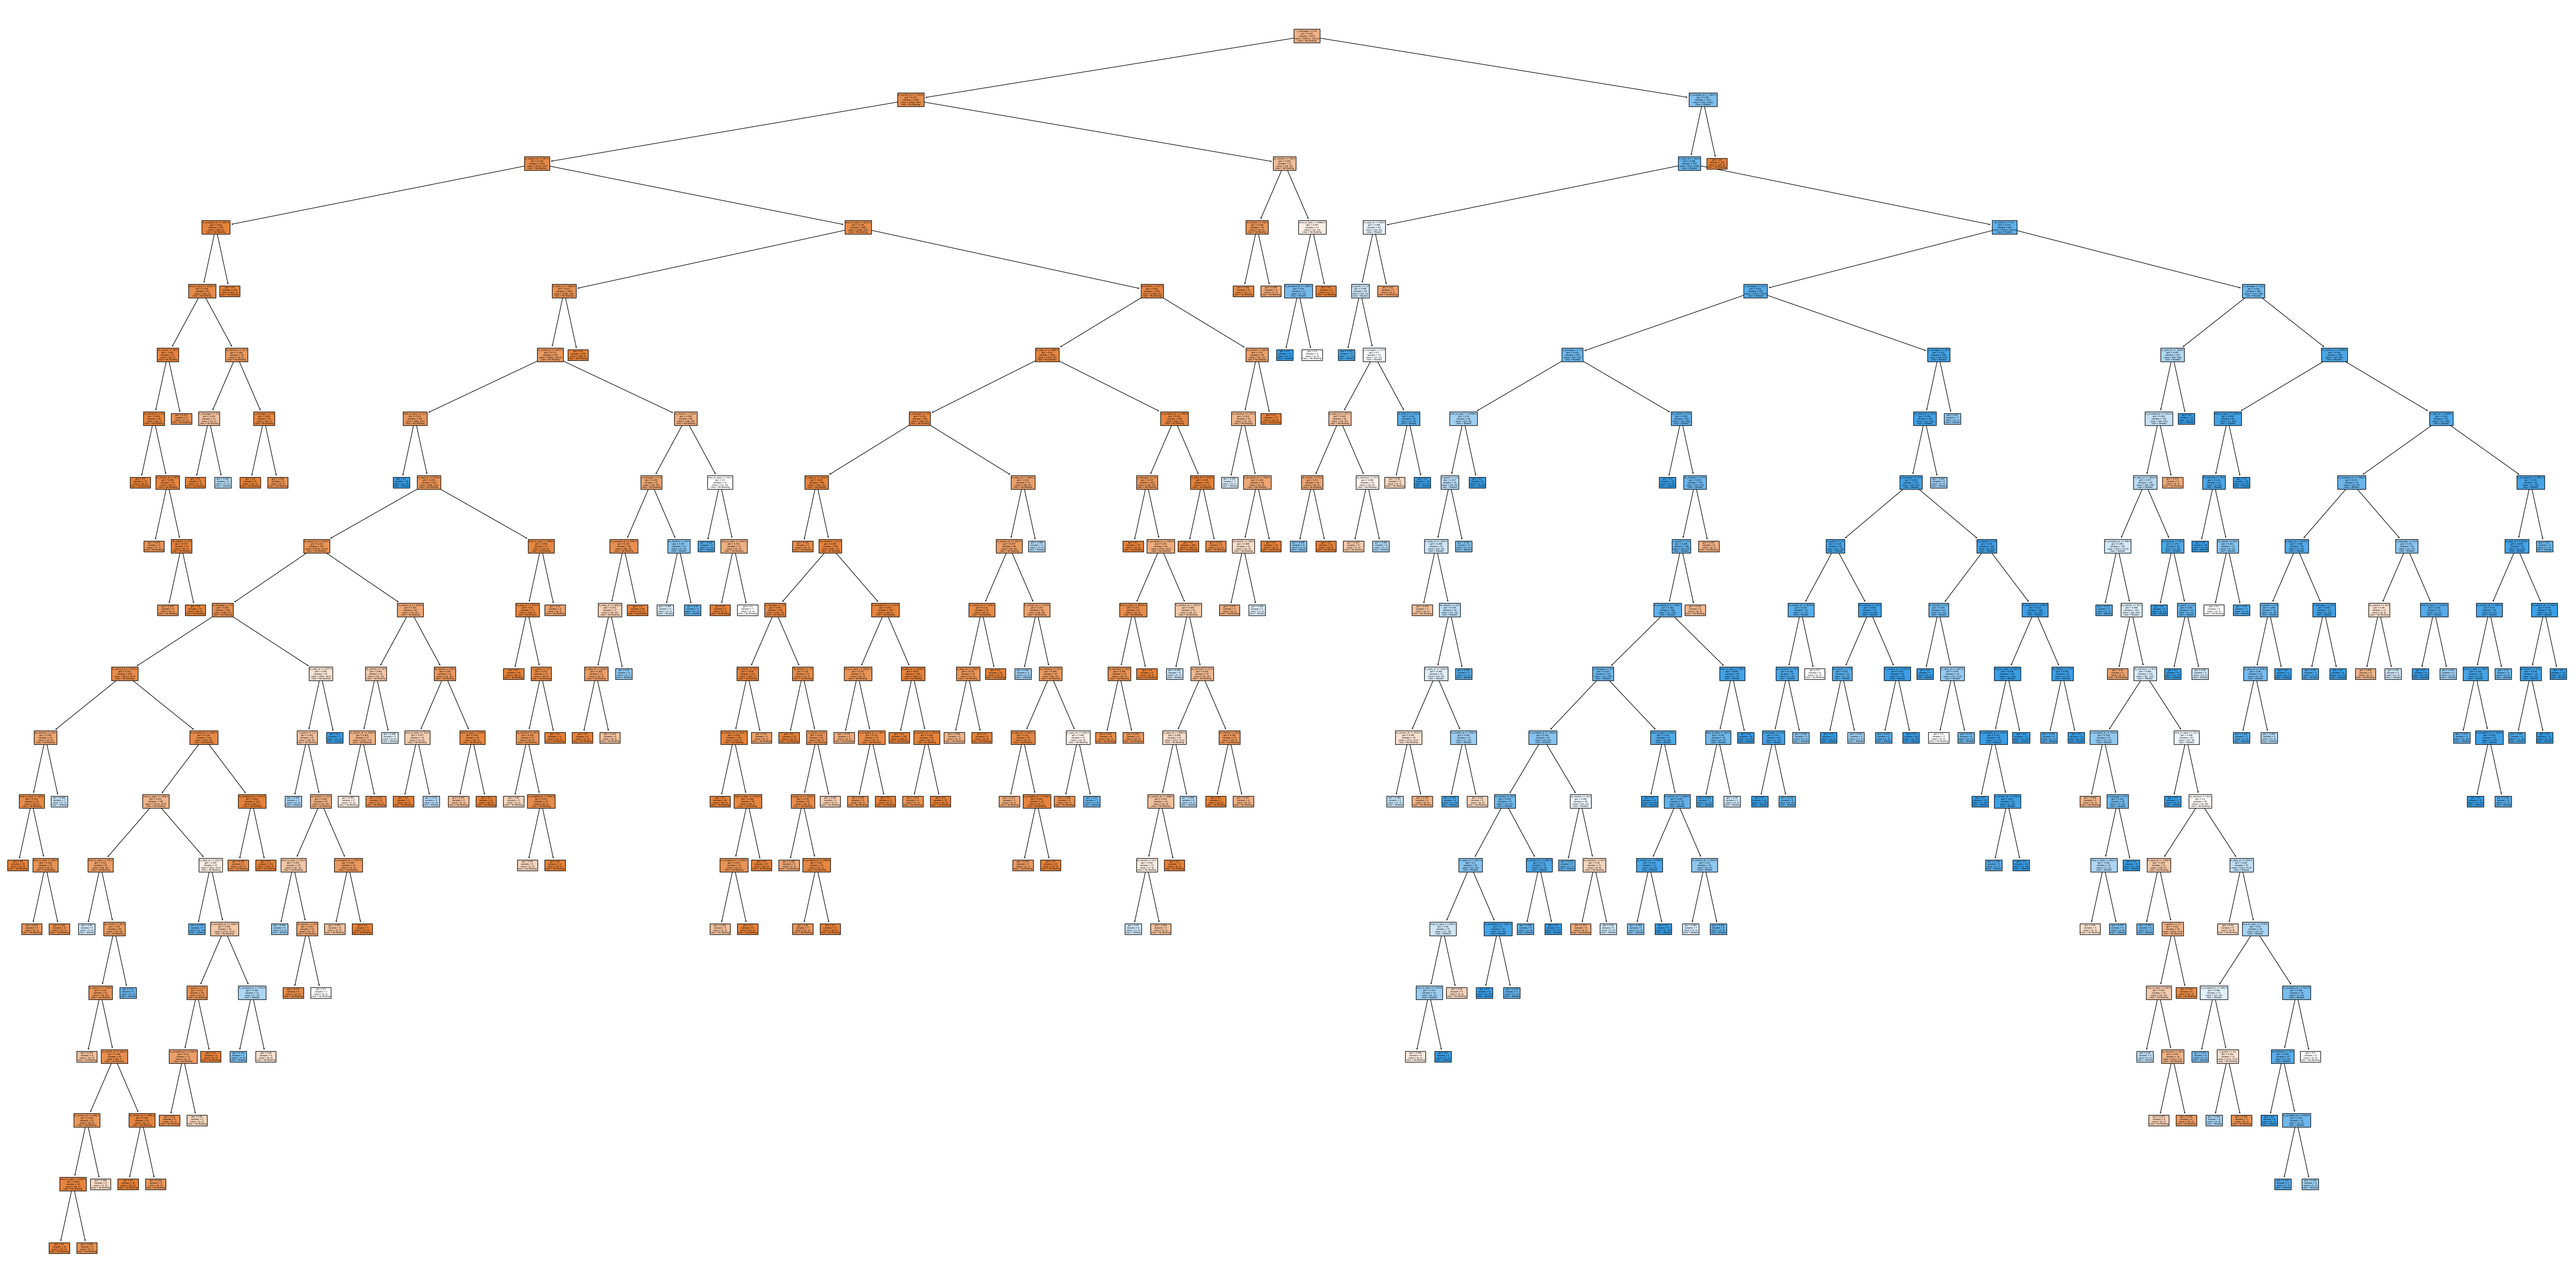

In [314]:
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,class_names=['No Booking', "Booked"],filled=True);

Identify most important features

In [316]:
selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X_train, y_train)
selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
print(selected_features)

Index(['ts_contact_at', 'ts_accepted_at', 'time_to_reply', 'ds_checkout',
       'n_messages'],
      dtype='object')


Use best params from sweep

In [317]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20,
                                       n_estimators=100, min_samples_leaf=5, oob_score=True)

In [318]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       oob_score=True, random_state=42)

In [319]:
classifier_rf.oob_score_

0.9178232286340394

In [320]:
classifier_rf.score(X_test, y_test)

0.9284192586280358

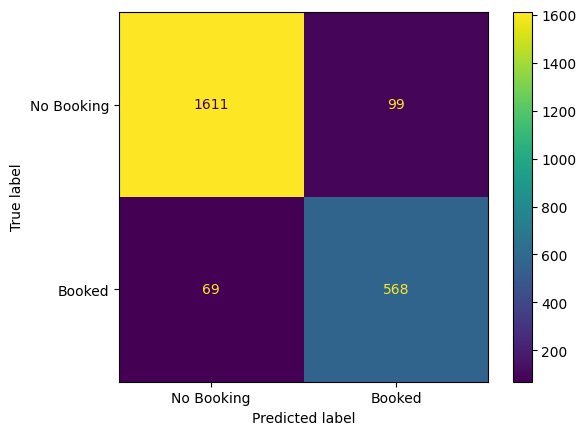

In [321]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, classifier_rf.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=['No Booking', 'Booked']).plot()